In [44]:
from RBFNN import RBFNN, ModelType
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import copy
import os
import time


class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
    'chua',
]
names = [n + '1d' for n in names]

n_dim = 1
horizon = 10
N = 10000

N_h = 200
num_prepare = 0
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
nz = 100
connectivity = 1
reservoirConf = Dict(
    alpha=0.9,
    connectivity= connectivity,
    nz= nz,
    nu = n_dim,
    target_rho=0.99,
    input_scale= 1
)

path = 'result/recursive_multistep_prediction'
if not os.path.exists(path):
    os.makedirs(path)


def gen_model(conf):
    _, model_type, kwargs = conf
    conf_dict = dict(
        model_type=model_type,
        **kwargs
    )
    return RBFNN(**conf_dict)


def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        model = gen_model(conf)
        model.train(x_train, y_train, num_prepare)
        Predictions = model.predict(x_test, num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model
    
    
for file in range(1,21):
    result_file = path + '/result_'+str(file) + '.csv'
    if os.path.exists(result_file):
        result = pd.read_csv(result_file)
    else:
        result = pd.DataFrame(columns=['datetime', 'system_name',  'n_dim', 'n_history', 'horizon', 'model_name', 'N_h', 'sigma','reservoir_encoder','nz', 'connectivity', 'mse'])

    process_start_time = time.time()
    print('开始数据处理')
    for system_name in names:
        for n_history in [10]:
        
            '''
            数据集
            '''
            x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
            x += np.random.randn(*x.shape)*0.001

            x_train = np.vstack([select_samples(x, train_start + i, num_train+num_prepare) for i in range(n_history)])
            y_train = select_samples(x, train_start+ num_prepare + n_history, num_train)
            x_test  = np.vstack([select_samples(x, test_start + i, num_test+num_prepare) for i in range(n_history)])
            y_test  = select_samples(x, test_start + num_prepare + n_history, num_test) 
            y_test_multi  = np.vstack([select_samples(x, test_start + num_prepare + n_history + i, num_test) 
                                for i in range(horizon)])

            rc = reservoirConf


            '''
            单步预测
            '''
            model_confs = []
            model_confs.append(
                [('ESN-trannsform', 
                ModelType.ESN, 
                dict(reservoirConf=rc,encoder='transform'))]
            )

            model_confs.append(
                [('RBFLN-RE-transform', 
                ModelType.RBFLN_RE, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc, encoder='transform')) 
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
            model_confs.append(
                [('ESN-ATTN-transform',
                ModelType.ESN_ATTN, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc,encoder='transform'))
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
#             model_confs += [('RBFLN',ModelType.RBFLN, dict(N_h=N_h, sigma=sigma))
#                             for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             model_confs += [('RBFN',ModelType.RBFN, dict(N_h=N_h, sigma=sigma))
#                             for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             model_confs += [('VAR',ModelType.VAR, dict())]


            colors = list(cnames.keys())


            for j, confs in enumerate(model_confs):
            
                conf = select_model(confs)
                
                model_name, model_type, kwargs = conf
                print(model_name)
                
                conf_dict = dict(
                    model_type=model_type,
                    **kwargs
                )

                model = RBFNN(**conf_dict)
                model.train(x_train, y_train, num_prepare)
                pred = model.predict_multistep(x_test, horizon)
                
#                 plt.figure(figsize=(25,horizon+1))
#                 plt.subplot(horizon+1, 1, 1)
#                 plt.plot(x_test[-1])
#                 for i in range(horizon):
#                     plt.subplot(horizon+1,1,i+2)
#                     error = np.sum(np.square(pred[i*n_dim:(i+1)*n_dim,:] - y_test_multi[i*n_dim:(i+1)*n_dim,:]), axis=0)
# #                     print(len(error[error<1])/len(error))
#                     plt.plot(error)
#                 plt.show()
                error = np.sum(np.square(pred[-n_dim:,:] - y_test_multi[-n_dim:,:]), axis=0)
                print('{}% data within range'.format(len(error[error<1])/len(error)*100))
                if len(error[error<1])/len(error) < 0.9:
                    print('bad case for analysis, drop it')
                    continue
                mask = error<1
                MSE = [np.average(np.sum(np.square(pred[i*n_dim:(i+1)*n_dim,mask] - y_test_multi[i*n_dim:(i+1)*n_dim,mask]), axis=0)) for i in range(horizon)]
                print('MSE',MSE)

                for k in range(len(MSE)):
                    result.loc[result.shape[0]] = {
                        'datetime'          : pd.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                        'system_name'       : system_name,
                        'n_dim'             : n_dim,
                        'n_history'         : n_history,
                        'horizon'           : k+1,
                        'model_name'        : model_name,
                        'N_h'               : N_h,
                        'sigma'             : kwargs.get('sigma', 0),
                        'nz'                : nz,
                        'connectivity'      : connectivity,
                        'reservoir_encoder' : 0 if rc is None else 1,
                        'mse'               : MSE[k]
                    }
#                     print(result.loc[result.shape[0]-1])



    result.to_csv(result_file, index=False)

    print('结束数据处理')
    process_stop_time = time.time()

    # 差的时间戳
    diff_time = process_stop_time - process_start_time
    # 将计算出来的时间戳转换为结构化时间
    struct_time = time.gmtime(diff_time)
    # 减去时间戳最开始的时间 并格式化输出
    print('数据处理用了{0}年{1}月{2}日{3}小时{4}分钟{5}秒'.format(
        struct_time.tm_year - 1970,
        struct_time.tm_mon - 1,
        struct_time.tm_mday - 1,
        struct_time.tm_hour,
        struct_time.tm_min,
        struct_time.tm_sec
    ))

开始数据处理
ESN-trannsform
100.0% data within range
MSE [5.539016354049451e-06, 1.8964558276518727e-05, 4.9243132245610136e-05, 9.648060310524626e-05, 0.00017172443252726083, 0.00029804131265149766, 0.00046929650740954875, 0.0006564353594586718, 0.0008648460630882993, 0.0011758455916979454]
RBFLN-RE-transform
100.0% data within range
MSE [3.5187307214162517e-06, 8.88807020111083e-06, 1.969349465375277e-05, 3.429698379702542e-05, 5.086385966172919e-05, 7.323751359285271e-05, 0.0001035407824724839, 0.00014318446720275218, 0.0001955701046170684, 0.0002573274447603453]
ESN-ATTN-transform
100.0% data within range
MSE [4.4405525145067025e-06, 1.378376936009173e-05, 3.4717405983530566e-05, 6.392207427934804e-05, 9.744368172184112e-05, 0.00014290398125461174, 0.0002060321188230548, 0.0002855943126137601, 0.000387177057321966, 0.0005104000363175259]
ESN-trannsform
100.0% data within range
MSE [3.943319433763007e-06, 1.0015146580552886e-05, 2.2326347574563226e-05, 4.359238639048511e-05, 7.41004418838

C:\Users\MONKEY\Desktop\RBFNN\RBFNN\RBFNN.py:139: RuntimeWarning: invalid value encountered in true_divide
  return fx / fx_sum
D:\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in less
D:\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in less
D:\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in less


97.95% data within range
MSE [1.1082886795893601e-05, 7.033119124921869e-05, 0.0003213289950924339, 0.0012446520787772364, 0.003945910439424208, 0.009293730586784264, 0.019161396857837902, 0.03637877241371201, 0.0509701337862796, 0.06969200694128187]
ESN-trannsform
100.0% data within range
MSE [2.3528613277178118e-05, 0.0001632130976472892, 0.0005710229829859413, 0.001357652607819467, 0.0024878507810844235, 0.0037741883125034137, 0.005018209540953738, 0.006132054462204435, 0.007069040080180663, 0.007538869387421022]
RBFLN-RE-transform
100.0% data within range
MSE [2.696987307872552e-05, 0.00019618842081013066, 0.0006834543241462613, 0.001564081614669409, 0.002716410180320403, 0.003899579992036662, 0.004920568215346998, 0.005742978495336229, 0.006420662296077396, 0.0070299135049332545]
ESN-ATTN-transform
100.0% data within range
MSE [2.3901531076452292e-05, 0.00016617486061102176, 0.0005813374215450876, 0.0013744549711860734, 0.0024663731040580963, 0.0036129483909786543, 0.0045781938284

ESN-ATTN-transform
100.0% data within range
MSE [4.675257475034148e-06, 1.324865940402055e-05, 3.073992845088369e-05, 5.129581890295025e-05, 7.360331958161712e-05, 0.00010748241814660732, 0.0001572983221202037, 0.00022020048548575805, 0.0002968081893528086, 0.0003795894843720219]
ESN-trannsform
100.0% data within range
MSE [4.119048499303786e-06, 1.153819208117216e-05, 2.7838141559616934e-05, 5.67409885155287e-05, 0.00010352571644177666, 0.00017008368869042182, 0.00025971766104614027, 0.000369221987714211, 0.0004924532480470499, 0.0006175169801247361]
RBFLN-RE-transform
100.0% data within range
MSE [3.8021422372073776e-06, 9.707842024166962e-06, 2.1241407084123062e-05, 3.907779514567708e-05, 6.215881826974826e-05, 8.80967638137687e-05, 0.00011775257175595849, 0.0001487945905806858, 0.00018380461027752595, 0.00022068131154358856]
ESN-ATTN-transform
100.0% data within range
MSE [3.658391262426741e-06, 8.825088083986673e-06, 1.8856190961228273e-05, 3.485610366548982e-05, 5.773784425460940

ESN-ATTN-transform
97.1% data within range
MSE [1.1301251010615966e-05, 7.622769225466136e-05, 0.00037513585688612024, 0.001546165512161678, 0.0055932637042720125, 0.016542600097821308, 0.04363967290225761, 0.0764580777638268, 0.09176684460332249, 0.08522606149351919]
ESN-trannsform
100.0% data within range
MSE [2.2045290352077918e-05, 0.00014998330658541758, 0.0005222261311908869, 0.0012305024186852148, 0.0022494168599455746, 0.0034549764064767154, 0.004714605386716099, 0.005921470665746933, 0.006956012335468383, 0.00764702441150558]
RBFLN-RE-transform
100.0% data within range
MSE [2.6701592207824995e-05, 0.0001875548421504766, 0.0006409765401937855, 0.0014489459569554373, 0.0024974076488365735, 0.0036167359849533704, 0.0047414583013343364, 0.005948092681932033, 0.00726392889626589, 0.00844814529197542]
ESN-ATTN-transform
100.0% data within range
MSE [2.235452840433237e-05, 0.00015296895348919948, 0.0005286386891197254, 0.0012246260022424473, 0.0021974542925535987, 0.00329687480495296

C:\Users\MONKEY\Desktop\RBFNN\RBFNN\RBFNN.py:129: RuntimeWarning: invalid value encountered in less
  D[D < 0] = 0


97.55% data within range
MSE [1.0181291003101624e-05, 6.376337510148391e-05, 0.00026622136204588326, 0.0008507853038454123, 0.0022839224291169545, 0.005107447084713776, 0.009694890020226651, 0.016822725927400518, 0.027751188194371636, 0.048026833944188434]
ESN-trannsform
100.0% data within range
MSE [2.2148063470180197e-05, 0.00015389413005747433, 0.0005513041191001919, 0.001350314929902566, 0.0025427934709181883, 0.003962451984461742, 0.00539730575407277, 0.006738764995640184, 0.008019077413479696, 0.009139471800604466]
RBFLN-RE-transform
100.0% data within range
MSE [2.6103124753549787e-05, 0.00018997853847725494, 0.0006611892212560615, 0.0015164641060019263, 0.0026304501322027495, 0.0037664075912525307, 0.004753480796364233, 0.005557839661408672, 0.00628523198034906, 0.007028519252689182]
ESN-ATTN-transform
100.0% data within range
MSE [2.1570846664872802e-05, 0.000144784281017842, 0.0005058314612119363, 0.0012030108252659149, 0.0021806656122945523, 0.0032933928971308154, 0.00441536

ESN-ATTN-transform
100.0% data within range
MSE [4.37746128188729e-06, 1.1890009810957407e-05, 2.6818875467812065e-05, 4.471193363338329e-05, 6.631701488200357e-05, 9.819344174355482e-05, 0.00014031450011042727, 0.000186710152660647, 0.0002403830184756704, 0.0003066284382787471]
ESN-trannsform
100.0% data within range
MSE [3.833311871690895e-06, 1.0191236369977998e-05, 2.340205381423444e-05, 4.6971808369773756e-05, 8.271910271554053e-05, 0.00013116544421992114, 0.00019361337102401832, 0.0002680795811623984, 0.0003500998318763011, 0.00043427766365953515]
RBFLN-RE-transform
100.0% data within range
MSE [3.60000399438271e-06, 8.39528604477858e-06, 1.7351435816609476e-05, 3.1696234368669684e-05, 5.0960486624271376e-05, 7.54355719282471e-05, 0.00010589971171544715, 0.00014125005972274885, 0.0001817275579460651, 0.00022686397986685963]
ESN-ATTN-transform
100.0% data within range
MSE [3.6457402246811406e-06, 9.120899650837111e-06, 1.995596057264628e-05, 3.7804762890366465e-05, 6.2933517865335

KeyboardInterrupt: 

# result analysis

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime



system_names = ['lorentz','rossler','rabinovich_fabrikant','chua']
system_names = [system + '1d' for system in system_names]

path = 'result/recursive_multistep_prediction'
# path = 'result/direct_multistep_prediction'
result_file0 = path + '/result_0.csv' 
print(result_file0)
df = pd.read_csv(result_file0, index_col = 'datetime')
df.index = pd.DatetimeIndex(df.index)
print(set(df['model_name']))
df

result/recursive_multistep_prediction/result_0.csv
{'ESN-trannsform', 'RBFLN-RE-transform', 'ESN-ATTN-transform'}


,system_name,n_dim,n_history,horizon,model_name,N_h,sigma,reservoir_encoder,nz,connectivity,mse
datetime,,,,,,,,,,,
2020-07-31 16:31:00,rossler1d,1,10,1,ESN-trannsform,200,0.00,1,100,1,0.000005
2020-07-31 16:31:00,rossler1d,1,10,2,ESN-trannsform,200,0.00,1,100,1,0.000014
2020-07-31 16:31:00,rossler1d,1,10,3,ESN-trannsform,200,0.00,1,100,1,0.000034
2020-07-31 16:31:00,rossler1d,1,10,4,ESN-trannsform,200,0.00,1,100,1,0.000056
2020-07-31 16:31:00,rossler1d,1,10,5,ESN-trannsform,200,0.00,1,100,1,0.000083
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 16:33:00,chua1d,1,10,6,ESN-ATTN-transform,200,0.25,1,100,1,0.003499
2020-07-31 16:33:00,chua1d,1,10,7,ESN-ATTN-transform,200,0.25,1,100,1,0.004629
2020-07-31 16:33:00,chua1d,1,10,8,ESN-ATTN-transform,200,0.25,1,100,1,0.005507


lorentz1d


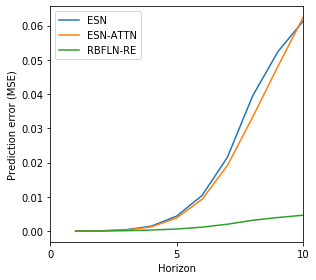

rossler1d


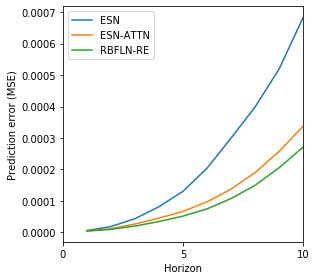

rabinovich_fabrikant1d


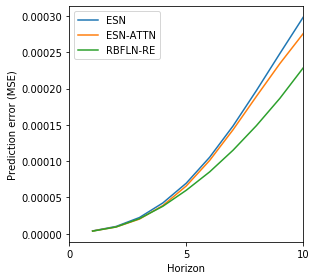

chua1d


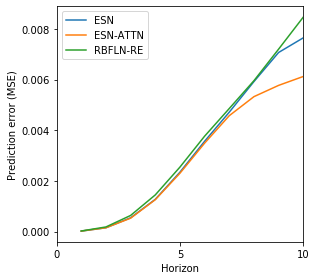

In [82]:
model_names = ['ESN-trannsform',  'ESN-ATTN-transform','RBFLN-RE-transform',]

for system_name in system_names:
    print(system_name)

    average = pd.DataFrame()
    for i in range(9):
        result_file = path + '/result_' +str(i) + '.csv' 
        df = pd.read_csv(result_file, index_col = 'datetime')
        df.index = pd.DatetimeIndex(df.index)

        result = df[df['system_name'].isin([system_name]) & 
                    df['model_name'].isin(model_names) & 
                    df['horizon'].isin(list(range(11)))]


        final = None
        for w in set(result['horizon']):

            temp = result.loc[result['horizon'] == w, ['model_name', 'mse', 'horizon']].groupby('model_name').min().reset_index()

            final = temp if final is None else final.append(temp, ignore_index=True)

        average = average.append(final,ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(4.5,4))

    
    for name in model_names:
        average.loc[average['model_name'] == name].groupby('horizon').median().sort_values(by='horizon').plot(ax = ax)

 
    plt.legend(labels= ['ESN',  'ESN-ATTN','RBFLN-RE',], loc='upper left')
#     ax.set_yscale("log")
#     ax.set_xscale("log")
    plt.xlabel('Horizon')
    plt.ylabel('Prediction error (MSE)')
    plt.xticks([0,5,10])
    plt.tight_layout()

    plt.savefig(path+'/'+system_name+'_horizon.pdf')
    plt.show()